# Experimental Variogram and Variogram Cloud classes

## Table of Contents:

1. Create Experimental Variogram with the `ExperimentalVariogram` class.
2. Create Experimental Variogram Point Cloud with the `VariogramCloud` class.

## Introduction

The geostatistical analysis starts with a dissimilarity estimation. We must know if a process is spatially dependent and at which distance points tend to be related to each other. Thus, we start with the experimental variogram estimation.
In this tutorial, we will look closely into the API and learn what can be done with two basic experimental semivariogram estimation functionalities. One is the `ExperimentalVariogram` class, and another is the `VariogramCloud` class. The first is a foundation of every other complex function, from semivariogram modeling to Poisson Kriging. The latter is used to analyze relations between points and their dispersion.

We will use **DEM data** stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`

## Import packages & read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinterpolate import read_txt, ExperimentalVariogram, VariogramCloud

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

# Take a sample
sample_size = int(0.05 * len(dem))
indices = np.random.choice(len(dem), sample_size, replace=False)
dem = dem[indices]

# Look into a first few lines of data
dem[:10, :]

array([[2.41661547e+05, 5.37106156e+05, 1.56584072e+01],
       [2.39830169e+05, 5.47469930e+05, 8.91886215e+01],
       [2.52772215e+05, 5.50460716e+05, 7.42563171e+01],
       [2.39122771e+05, 5.47254134e+05, 8.59083939e+01],
       [2.54889391e+05, 5.51091269e+05, 7.20493927e+01],
       [2.47079296e+05, 5.30409100e+05, 4.63409996e+01],
       [2.46072757e+05, 5.52214231e+05, 5.38786583e+01],
       [2.53401471e+05, 5.38619345e+05, 2.30167007e+01],
       [2.40449088e+05, 5.44529941e+05, 1.66461201e+01],
       [2.53916790e+05, 5.47726919e+05, 6.56468353e+01]])

## 1. Experimental Variogram class

Let's start from the `ExperimentalVariogram` class.

```python

class ExperimentalVariogram:
    
    def __init__(self,
                 input_array,
                 step_size,
                 max_range,
                 weights=None,
                 direction=None,
                 tolerance=1.0,
                 method='t',
                 is_semivariance=True,
                 is_covariance=True):
        ...

```

The class has three required parameters and seven optional.

- `input_array` is a list of coordinates and values in the form `(x, y, value)`. Those are our observations.
- `step_size` parameter, which describes the distance between lags.
- `max_range`, which describes the maximum range of analysis.

What do we know at the beginning? Our coordinate reference system is metric. It is [EPSG:2180](https://epsg.io/2180). We don't know the limits of the region of interest to set the `max_range` parameter. We must define our area size:

In [3]:
# Get max distances for a region

minx = np.min(dem[:, 0])
maxx = np.max(dem[:, 0])

miny = np.min(dem[:, 1])
maxy = np.max(dem[:, 1])

x_max_distance = maxx - minx
y_max_distance = maxy - miny

print('Max lon distance:', x_max_distance)
print('Max lat distance:', y_max_distance)

Max lon distance: 17730.22780098894
Max lat distance: 24552.577515464276


We can assume that the maximum distance `max_range` parameter shouldn't be larger than the maximum distance in a lower dimension (**~18000** m). In reality, the `max_range` parameter is relatively close to the halved value of this distance, and we can check it on a variogram.

But we don't know the `step_size` parameter... Let's assume it is 100 meters, and we will see if we've estimated it correctly.

In [4]:
max_range = 18000
step_size = 100

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

We will visually inspect semivariogram with the `.plot()` method of `ExperimentalVariogram` class: 

In [5]:
experimental_variogram.plot(plot_covariance=False, plot_variance=False)

Variogram looks nice. We can see a trend, but points are oscillating around it. This piece of information tells us that `step_size` should be larger.

What with the `max_range`? It is a tricky problem because the semivariogram seems right up to the end of its range. The idea is to set the maximum range around half of the study extent because the number of point pairs will fall from this distance.

We can check how many point pairs we have for each distance to make a better decision. The `ExperimentalVariogram` class stores information about points within its attribute `.experimental_semivariance_array`. It is a `numpy` array with three columns: `[lag, semivariance, number of point pairs]`, and we will use the last column to decide where to cut `max_range`.

In [6]:
_ds = experimental_variogram.experimental_semivariance_array
plt.figure()
plt.scatter(x=_ds[:, 0], y=_ds[:, -1])
plt.show()

Around the twelve-kilometer number of point pairs rapidly falls, so we can set `max_range` to some value between 7.5 and 12.5 kilometers, we will choose **10000** kilometers as our `max_range`.

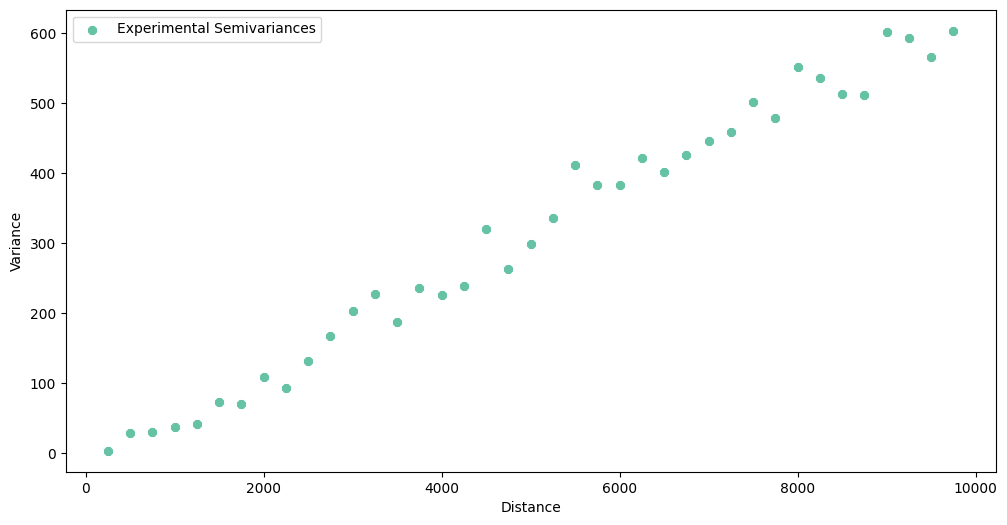

In [7]:
max_range = 10_000
step_size = 250

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

experimental_variogram.plot(plot_covariance=False, plot_variance=False)

This time variogram looks cleaner. However, it still has oscillating readings. Let's set `step_size` to 500 meters:

In [8]:
step_size = 500

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

experimental_variogram.plot(plot_covariance=False, plot_variance=False)

We can use those parameters! Next, we will look into the `is_covariance` parameter of the `ExperimentalVariogram` class. It is set to `True` by default. If we want to know the covariance of a dataset, then we should set the `is_covariance` parameter to `True`. Covariance is a measure of spatial similarity, opposite to semivariance. You will see in the plot that they mirror each other. But we can use it in kriging systems instead of semivariance.

`ExperimentalVariogram` plotting function `.plot()` has additional parameters:

- `plot_semivariance` (boolean, set to `True` by default),
- `plot_covariance` (boolean, set to `True` by default),
- `plot_variance` (boolean, set to `True` by default).

We will plot all of those objects in a single figure.


In [9]:
experimental_variogram.plot()

Two important things that we can read from this plot:

1. Experimental covariance is a mirrored version of experimental semivariance, and we can use it to solve the Kriging system instead of semivariance. It is a measure of similarity between point pairs. The highest similarity can be noticed on the first lags and decreases with a rising distance.
2. Variance calculated from data is used later as the **sill** in kriging models, and it can be used to transform semivariances into covariances.

This plot summarizes the basic steps we can do with the `ExperimentalVariogram` class. We left many parameters untouched, but only for a moment. Now we are going to explore all capabilities of the class.

### Optional parameter: `weights`

We won't use this parameter in our tutorial, but we should learn where it comes from. It is a part of **Poisson Kriging** operations. **Poisson Kriging** algorithms use `weights` to weight the semivariance between blocks by in-block population.


### Optional parameters: `direction, tolerance, method`

Those three parameters are used to define a directional variogram. We will check how the variogram behaves in the Weast-East axis (0 degrees).

In [10]:
direction = 0
tolerance = 0.1
method = 'e'


experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range,
    direction=direction,
    tolerance=tolerance,
    method=method
)

experimental_variogram.plot()

Let's look into the North-South axis too:

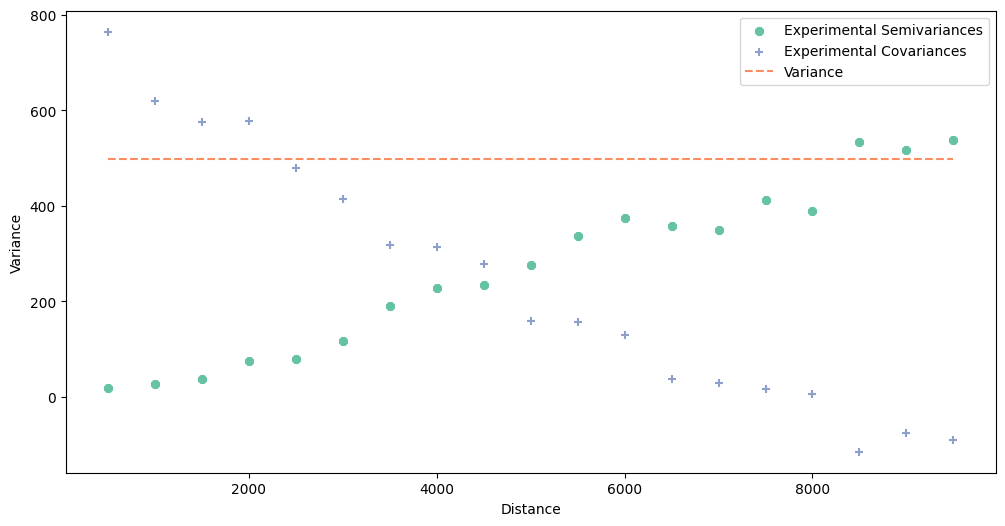

In [11]:
direction = 90

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range,
    direction=direction,
    tolerance=tolerance,
    method=method
)

experimental_variogram.plot()

What can we learn from those plots? Variability along the W-E axis is lower than along the N-S axis. It may indicate continuous spatial structures along the W-E axis (for example, a river plain).

At this point, we are ready for modeling. However, if we want to be precise, we should look into outliers and analyze `VariogramCloud`.

A classic variogram analysis tells us almost everything about spatial dependencies and dissimilarities in data. But there are more spatial investigation tools. We need to learn about the distribution of variances within a single lag, which is valuable information. Semivariogram shows us averaged semivariances. If we want to dig deeper, we should use the `VariogramCloud` class and plot... the variogram cloud.

The `VariogramCloud` class definition API is:

```python

class VariogramCloud:

    def __init__(self,
                 input_array,
                 step_size,
                 max_range,
                 direction=0,
                 tolerance=1,
                 calculate_on_creation=True):
    pass

```

We pass the same parameters to the class as for the `ExperimentalVariogram` class, and the only difference is the `calculate_on_creation` boolean value. Variogram point cloud calculation is a slow operation, and that's why we can start it during or after the class initialization. If we set `calculate_on_creation` to `False`, we must run the `.calculate_experimental_variogram()` method later.

`VariogramCloud` has more methods than `ExperimentalVariogram`:

- `calculate_experimental_variogram()` to obtain the variogram (similar to the output from the `ExperimentalVariogram` class,
- `describe()` to get lag statistics,
- `plot()` to plot variogram cloud,
- `remove_outliers()` to clean the variogram.

We will start with calculation and plotting variogram cloud.

In [12]:
variogram_cloud = VariogramCloud(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

We can plot three different kinds of distribution plots: `'scatter', 'box', 'violin'`. We will choose `box` because it clearly shows data distribution in contrast to `scatter` and it's easier to interpret than `violin` plot.

In [13]:
variogram_cloud.plot(kind='box')

True

The general shape is similar to the shape of the experimental variogram. We can see that semivariances between point pairs contain outliers, especially for the lags close to our maximum range. To be sure about outliers' existence, let's look into a more complex violin plot:

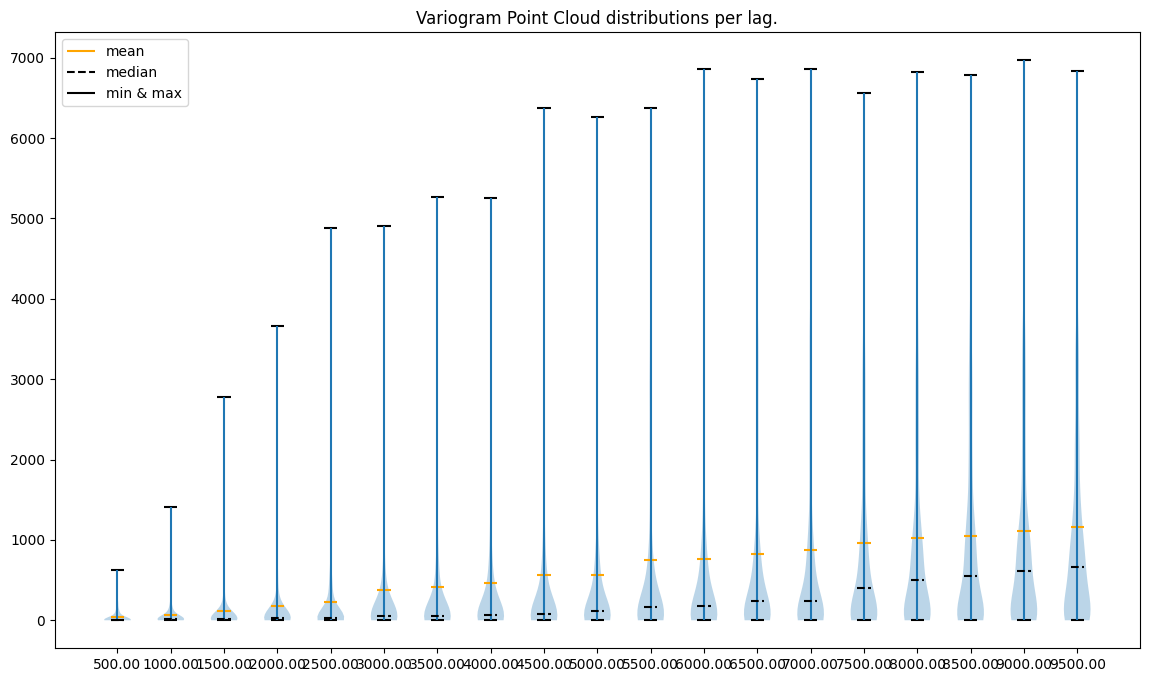

True

In [14]:
variogram_cloud.plot(kind='violin')

Extreme outliers are more visible. Another thing is the difference between the mean and median. Distribution is highly skewed toward large values. If graphical representation is not enough, we may describe statistics with the method `.describe()`:

In [15]:
variogram_cloud.describe()

{500: {'count': 206,
  'avg semivariance': 21.766971989327978,
  'std': 99.45858752750664,
  'min': 0.00040093438292387873,
  'max': 620.3486521877348,
  '25%': 0.31618772951424035,
  'median': 2.6660517454729415,
  '75%': 40.530090990665485,
  'skewness': 3.951161453959655,
  'kurtosis': 18.051674496024585,
  'lag': 500},
 1000: {'count': 626,
  'avg semivariance': 34.026074053022796,
  'std': 164.31425739577926,
  'min': 0.00010762131205410697,
  'max': 1404.338628287791,
  '25%': 1.3114497620299517,
  'median': 13.795076344162226,
  '75%': 57.276079500457854,
  'skewness': 4.877955962596052,
  'kurtosis': 27.891537698567358,
  'lag': 1000},
 1500: {'count': 1034,
  'avg semivariance': 57.732919734515775,
  'std': 313.5418161290796,
  'min': 0.000324399476085091,
  'max': 2779.9481918220736,
  '25%': 1.4431987959542312,
  'median': 16.274205634967075,
  '75%': 94.3718891301105,
  'skewness': 5.455441858944847,
  'kurtosis': 34.29966174391724,
  'lag': 1500},
 2000: {'count': 1264,
  

We get Python's `dict` as an output, but it is not especially readable; let's convert it to a `DataFrame`:

In [16]:
desc = pd.DataFrame(variogram_cloud.describe())

In [17]:
desc

500          1000         1500         2000  \
count             206.000000   626.000000  1034.000000  1264.000000   
avg semivariance   21.766972    34.026074    57.732920    90.053339   
std                99.458588   164.314257   313.541816   459.015329   
min                 0.000401     0.000108     0.000324     0.000001   
max               620.348652  1404.338628  2779.948192  3666.732274   
25%                 0.316188     1.311450     1.443199     1.769417   
median              2.666052    13.795076    16.274206    22.424686   
75%                40.530091    57.276080    94.371889   122.828298   
skewness            3.951161     4.877956     5.455442     4.267597   
kurtosis           18.051674    27.891538    34.299662    20.274428   
lag               500.000000  1000.000000  1500.000000  2000.000000   

                          2500         3000         3500         4000  \
count             1.750000e+03  2028.000000  2162.000000  2342.000000   
avg semivariance  1.126292e+02   186.296777   206.685868   230.205339   
std               5.181359e+02   801.225400   836.211161   891.621269   
min               3.541354e-07     0.000010     0.000081     0.000110   
max               4.884372e+03  4902.460445  5262.414517  5256.594053   
25%               2.752833e+00     3.615103     4.305628     5.180789   
median            2.304713e+01    47.315267    56.753690    68.192979   
75%               1.952224e+02   269.802530   373.089361   436.196793   
skewness          4.259865e+00     3.034958     2.925237     2.757475   
kurtosis          2.290186e+01     8.957808     8.817584     7.517835   
lag               2.500000e+03  3000.000000  3500.000000  4000.000000   

                         4500          5000          5500         6000  \
count             2642.000000  2.908000e+03  3.020000e+03  3272.000000   
avg semivariance   280.243393  2.814109e+02  3.753399e+02   383.087461   
std               1033.824009  9.941484e+02  1.204056e+03  1236.322337   
min                  0.000095  5.065522e-08  6.915652e-07     0.000011   
max               6374.667147  6.257543e+03  6.368261e+03  6859.651217   
25%                  5.608129  8.165557e+00  9.603393e+00    11.924021   
median              73.803111  1.098044e+02  1.635595e+02   175.987949   
75%                556.422417  5.768961e+02  8.174468e+02   865.617649   
skewness             2.482529  2.402884e+00  1.897221e+00     2.108062   
kurtosis             6.044861  5.605768e+00  2.874524e+00     4.058616   
lag               4500.000000  5.000000e+03  5.500000e+03  6000.000000   

                         6500         7000         7500         8000  \
count             3340.000000  3644.000000  3600.000000  3616.000000   
avg semivariance   410.900125   435.108791   480.320150   513.059296   
std               1230.748069  1293.761070  1295.761925  1318.059020   
min                  0.000169     0.000001     0.000091     0.000185   
max               6738.133075  6853.005667  6559.992730  6825.612907   
25%                 15.551828    13.923955    26.594895    34.245417   
median             239.011993   238.987623   403.543155   501.459609   
75%                968.981374  1073.179500  1340.484880  1419.279964   
skewness             1.847403     1.861000     1.709251     1.616490   
kurtosis             2.859044     3.029978     2.537015     2.106215   
lag               6500.000000  7000.000000  7500.000000  8000.000000   

                         8500         9000         9500  
count             3764.000000  3950.000000  3740.000000  
avg semivariance   523.965981   556.138199   578.503844  
std               1311.031836  1389.725337  1415.747255  
min                  0.001347     0.000095     0.001943  
max               6785.284915  6966.667973  6828.589286  
25%                 32.434151    45.418306    61.397283  
median             546.673465   618.736779   663.976540  
75%               1487.956373  1538.624619  1632.529093  
skewness          

With this detailed table, we can analyze the variogram in detail and decide:
- if lags are correctly placed,
- if there are enough points per lag,
- if the maximum range is too low or too high,
- is distribution close to normal,

And based on the answers to those questions, we can change semivariogram parameters slightly.

The interesting row is `avg semivariance`. Let's plot it against lags, and let's plot the output from `ExperimentalVariogram` in the same figure:

In [18]:
# Re-calculate experimental variogram

max_range = 10000
step_size = 500

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

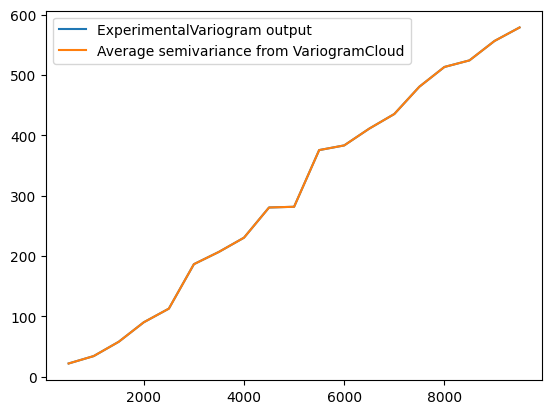

In [19]:
# Plot

plt.figure()
plt.plot(experimental_variogram.experimental_semivariance_array[:, 0], 
         experimental_variogram.experimental_semivariance_array[:, 1])
plt.plot(desc.loc['avg semivariance'])
plt.legend(['ExperimentalVariogram output', 'Average semivariance from VariogramCloud'])
plt.show()

The result is the same, and it shouldn't be a surprise. The experimental variogram averages all semivariances per lag. We stepped back in computations and focused on all point pairs within a lag.

There is one last method within the `VariogramCloud` class: `.remove_outliers()`. It cleans our variogram from anomalous readings. The cleaning default algorithm uses the z-score, but we can also use the interquartile range analysis. Both methods cut outliers from the largest or the lowest intervals. For data that deviates greately from normal distribution, it is better to use an inter-quartile range for cleaning:

In [20]:
new_variogram_cloud = variogram_cloud.remove_outliers(method='iqr', iqr_lower_limit=3, iqr_upper_limit=2)

Now we can check what has happend with the variogram:

In [21]:
new_variogram_cloud.plot(kind='violin')

True

Maximum semivariances are much lower than before. How does look the averaged semivariogram? Now we will use the `.calculate_experimental_variogram()` method to calculate the variogram directly and compare it to the experimental variogram retrieved from the `ExperimentalVariogram` class.

In [22]:
# Plot
exp_var_from_point_cloud = new_variogram_cloud.calculate_experimental_variogram()

plt.figure()
plt.plot(experimental_variogram.experimental_semivariance_array[:, 0], 
         experimental_variogram.experimental_semivariance_array[:, 1])
plt.plot(exp_var_from_point_cloud[:, 0], 
         exp_var_from_point_cloud[:, 1])
plt.legend(['ExperimentalVariogram output', 'Average semivariance from VariogramCloud'])
plt.show()

Now we see that the shape of the variogram persisted, but maximum values per lag are lower. It could be helpful for some models, especially if we eliminate outliers with extreme values.

## Summary

After all those steps, you have better insights into the `ExperimentalVariogram` and `VariogramCloud` classes. You may check your dataset and compare results to those in the tutorial.

The main takeaways from this tutorial are:

- API of `ExperimentalVariogram` and `VariogramCloud` classes,
- differences and similarities between `ExperimentalVariogram` and `VariogramCloud` classes,
- full variogram analysis and preparation before spatial interpolation.

---

## Where to go from here?

* B.1.1 Ordinary and Simple Kriging
* B.3.1 Directional Ordinary Kriging
* C.1.1 Outliers and Kriging Model

## Changelog

| Date       | Change description                                                              | Author                     |
|------------|---------------------------------------------------------------------------------|----------------------------|
| 2023-08-22 | The tutorial was refreshed and set along with the 0.5.0 version of the package  | @SimonMolinsky             |
| 2023-01-23 | The first release of the tutorial | @SimonMolinsky |